In [8]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.modeling.models import Voigt1D
from astropy.modeling import fitting
import seaborn as sns
from lmfit import Model, Parameters
from scipy.ndimage import gaussian_filter

In [9]:
def wavelength_edges(wavelength_data):
    diff = np.diff(wavelength_data)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) 
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) 
    w0 = wavelength_data - diff0/2.
    w1 = wavelength_data + diff1/2.

    return w0, w1

In [10]:
def smooth_data(wavelength_data, flux_data, error_data, sigma):
    # Smooth data
    smoothed_wavelength = gaussian_filter(wavelength_data, sigma)
    smoothed_flux = gaussian_filter(flux_data, sigma)
    smoothed_error = gaussian_filter(error_data, sigma)

    return smoothed_wavelength, smoothed_flux, smoothed_error

In [92]:
def grouping_emission_lines(min_wavelength, rest_lam_data):
    # Initialize variables
    tolerance = 10. # adjust me!
    ion_groups = {}
    close_group_found = False

    # Loop through emission lines
    for _, row in rest_lam_data.iterrows():
        # Extract ion name and wavelength
        ion = row["Ion"]
        wavelength = float(row["Wavelength"])

        if wavelength < min_wavelength: 
            continue

        # Check if ion already exists in the dictionary
        if ion not in ion_groups:
            ion_groups[ion] = [[wavelength]]
        else:
            # Reset
            close_group_found = False
            for group in ion_groups[ion]:
                # Check if the largest value in the group - wavelength is less than the tolerance
                if abs(max(group) - wavelength) <= tolerance:
                    group.append(wavelength)
                    close_group_found = True
                    break
            
            # If no close group was found
            if not close_group_found:
                ion_groups[ion].append([wavelength])

    return ion_groups

In [108]:
def split_create_trendline(wavelength_data, flux_data, peak_width_pixels):
    # Initialize variables
    length = len(wavelength_data) - 1
    flux_list_left = []
    flux_list_right = []
    
    # Make an array of all flux that aren't included in the peak
    for i in range(0, int(peak_width_pixels/2)):
        flux_list_left.append(flux_data[i])
        flux_list_right.append(flux_data[length-i])
        
    # Find the average flux for the left and right
    avg_flux_left = sum(flux_list_left)/len(flux_list_left)
    avg_flux_right = sum(flux_list_right)/len(flux_list_right)
    
    # Use the lesser of the two values as the average flux
    if avg_flux_left < avg_flux_right:
        avg_flux = avg_flux_left
    else:
        avg_flux = avg_flux_right
    
    continuum_array = [avg_flux for i in range(length + 1)]
    
    return continuum_array

In [109]:
def peak_width_finder(grating, wavelength_data):
    # Check grating
    if 'L' in grating:
        peak_width = 5.0
    else:
        peak_width = 0.5
        
    flux_range = 2*peak_width

    # Flux range in pixels calculation
    angstroms_to_pixels = wavelength_data[1] - wavelength_data[0] # NOTE! have to recalculate this number every time
    peak_width_pixels = math.floor(peak_width/angstroms_to_pixels)

    return peak_width, peak_width_pixels, flux_range

In [94]:
# Rest wavelengths
data = pd.read_csv("../DEM_goodlinelist .csv")
rest_df = pd.DataFrame(data)
rest_df.head(3)

,Ion,Wavelength,Likelihood to measure,Log Formation Temperature
0,S VI,933.397,Medium,5.3
1,N III,989.787,Medium,4.9
2,N III,991.495,Medium,4.9


In [98]:
# Group wavelengths
grouped_rest_data = grouping_emission_lines(1160, rest_df)

In [12]:
# HD 191939 data
data = fits.getdata('of0e53010_test_new_x1d.fits')
w, f , e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = (w > 1160) 
hd_wavelength_data, hd_flux_data, hd_error_data = w[mask], f[mask], e[mask]

# Print ecsv
hd191939_table = Table.read('hd-191939.ecsv', format='ascii.ecsv')
hd191939_df = hd191939_table.to_pandas()
hd191939_df.head(3)

,Ion,Rest Wavelength,Flux,Error,Blended Line
0,C III,1176.372,7.999070e-16,2.750151e-16,True
1,Si III,1206.499,-7.143874e-16,0.000000e+00,False
2,Si III,1303.323,-7.919437e-16,0.000000e+00,True


In [13]:
# Tau Ceti data
data = fits.getdata('hlsp_muscles_hst_stis_tau_ceti_e140m_v1_component-spec.fits')
w, f , e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = (w > 1160) # change if the spectra starts at a different wavelength
tc_wavelength_data, tc_flux_data, tc_error_data = w[mask], f[mask], e[mask]

# Print ecsv 
tc_table = Table.read('tau-ceti.ecsv', format='ascii.ecsv')
tc_df = tc_table.to_pandas()
tc_df.head(3)

,Ion,Rest Wavelength,Flux,Error,Blended Line
0,C III,1176.372,1.467025e-14,1.179191e-15,True
1,Si III,1206.499,3.085698e-14,8.772685e-16,False
2,Si III,1303.323,-1.681547e-15,0.000000e+00,True


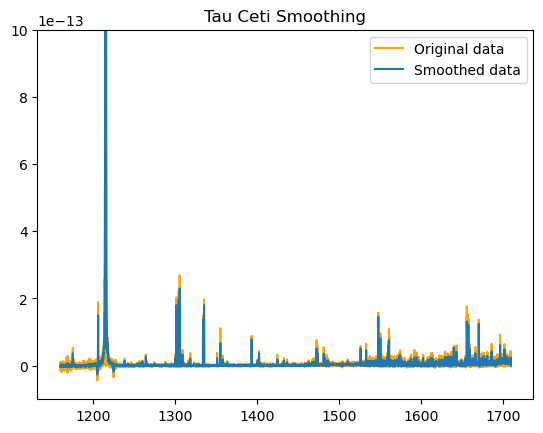

In [42]:
# Gaussian smoothing for tau ceti 
smoothtc_wavelength_data, smoothtc_flux_data, smoothtc_error_data = smooth_data(tc_wavelength_data, tc_flux_data, tc_error_data, 2)
plt.plot(tc_wavelength_data, tc_flux_data, label = 'Original data', color = 'orange')
plt.plot(smoothtc_wavelength_data, smoothtc_flux_data, label = 'Smoothed data')

plt.title("Tau Ceti Smoothing")
plt.ylim(-1e-13, 1e-12)
plt.legend()
plt.show()

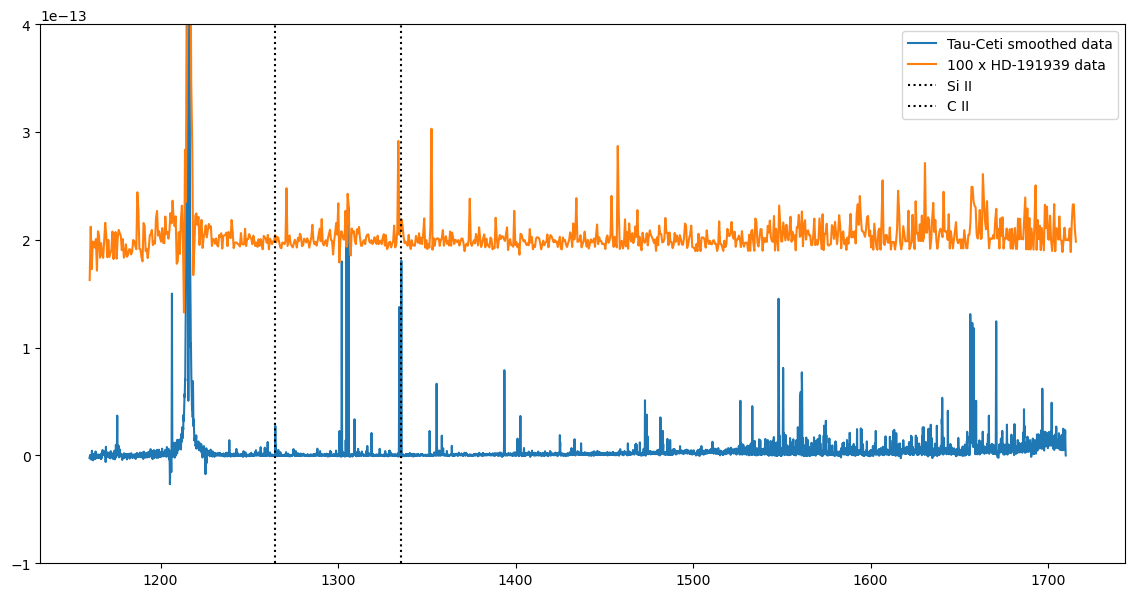

In [81]:
# Compare to HD-191939
plt.figure(figsize=(14,7))
plt.plot(smoothtc_wavelength_data, smoothtc_flux_data, label = 'Tau-Ceti smoothed data')
plt.plot(hd_wavelength_data, 2e-13 + 100*hd_flux_data, label = '100 x HD-191939 data')

# Plot line comparisons
plt.axvline(x = 1264.737, color = 'black', ls = 'dotted', label= 'Si II')
plt.axvline(x = 1335.709, color = 'black', ls = 'dotted', label= 'C II')
# plt.axvline(x = 1400, color = 'black', ls = 'dotted', label= 'C II')



plt.ylim(-1e-13, 4e-13)
plt.legend()
plt.show()

#### HD-191939 data is scaled up 100 time!

Si II lines at [1260.417, 1264.737, 1265.001]


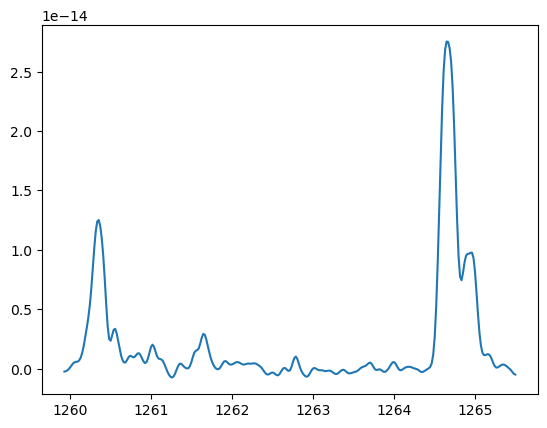

In [107]:
# Si II @ 1264 A
siII_lines = grouped_rest_data['Si II'][0]
print(f'Si II lines at {siII_lines}')

# Tau Ceti
tc_peak_width = 0.5
tc_siII_mask = (smoothtc_wavelength_data > siII_lines[0] - tc_peak_width) & (smoothtc_wavelength_data < siII_lines[2] + tc_peak_width)

# Calculate the continuum 
continuum = split_create_trendline(smoothtc_wavelength_data[tc_siII_mask], smoothtc_flux_data[tc_siII_mask], peak_width_pixels):

plt.plot(smoothtc_wavelength_data[tc_siII_mask], smoothtc_flux_data[tc_siII_mask])
plt.axhline()
plt.show()